# Machine Learning Regression Task
## Case Study:  Removing Inconsistencies in Concrete Compressive Strength
### By Samuel Waweru ,B.Sc.Mechatronic Engineering ,JKUAT 25

In [5]:
%matplotlib inline
import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import seaborn
from IPython.display import Image

### Feature Exploration

In [6]:
data=pd.read_excel("Concrete_Data.xls")
#print len(data)
data

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [7]:
#Renaming the Columns
data.columns = ['cement_component', 'furnace_slag', 'flay_ash', 
'water_component', 'superplasticizer', \
 'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']

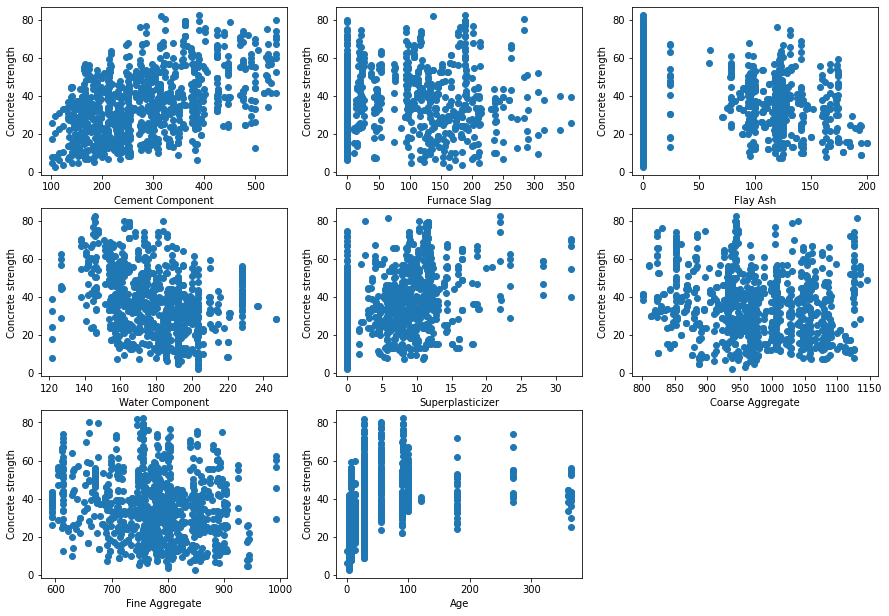

In [8]:
# Plotting Scatter Plots Between the Response and Exploratory Variables
plt.figure(figsize=(15,10.5))
plot_count = 1
for feature in list(data.columns)[:-1]:
    plt.subplot(3,3,plot_count)
    plt.scatter(data[feature], data['concrete_strength'])
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    plot_count+=1
plt.show()

In [9]:
#Calculating Pair-wise Pearson Correlations
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data.corr(method='pearson')
print(correlations)

                   cement_component  furnace_slag  flay_ash  water_component  superplasticizer  \
cement_component              1.000        -0.275    -0.397           -0.082             0.093   
furnace_slag                 -0.275         1.000    -0.324            0.107             0.043   
flay_ash                     -0.397        -0.324     1.000           -0.257             0.377   
water_component              -0.082         0.107    -0.257            1.000            -0.657   
superplasticizer              0.093         0.043     0.377           -0.657             1.000   
coarse_aggregate             -0.109        -0.284    -0.010           -0.182            -0.266   
fine_aggregate               -0.223        -0.282     0.079           -0.451             0.223   
age                           0.082        -0.044    -0.154            0.278            -0.193   
concrete_strength             0.498         0.135    -0.106           -0.290             0.366   

                   

Note: you may need to restart the kernel to use updated packages.


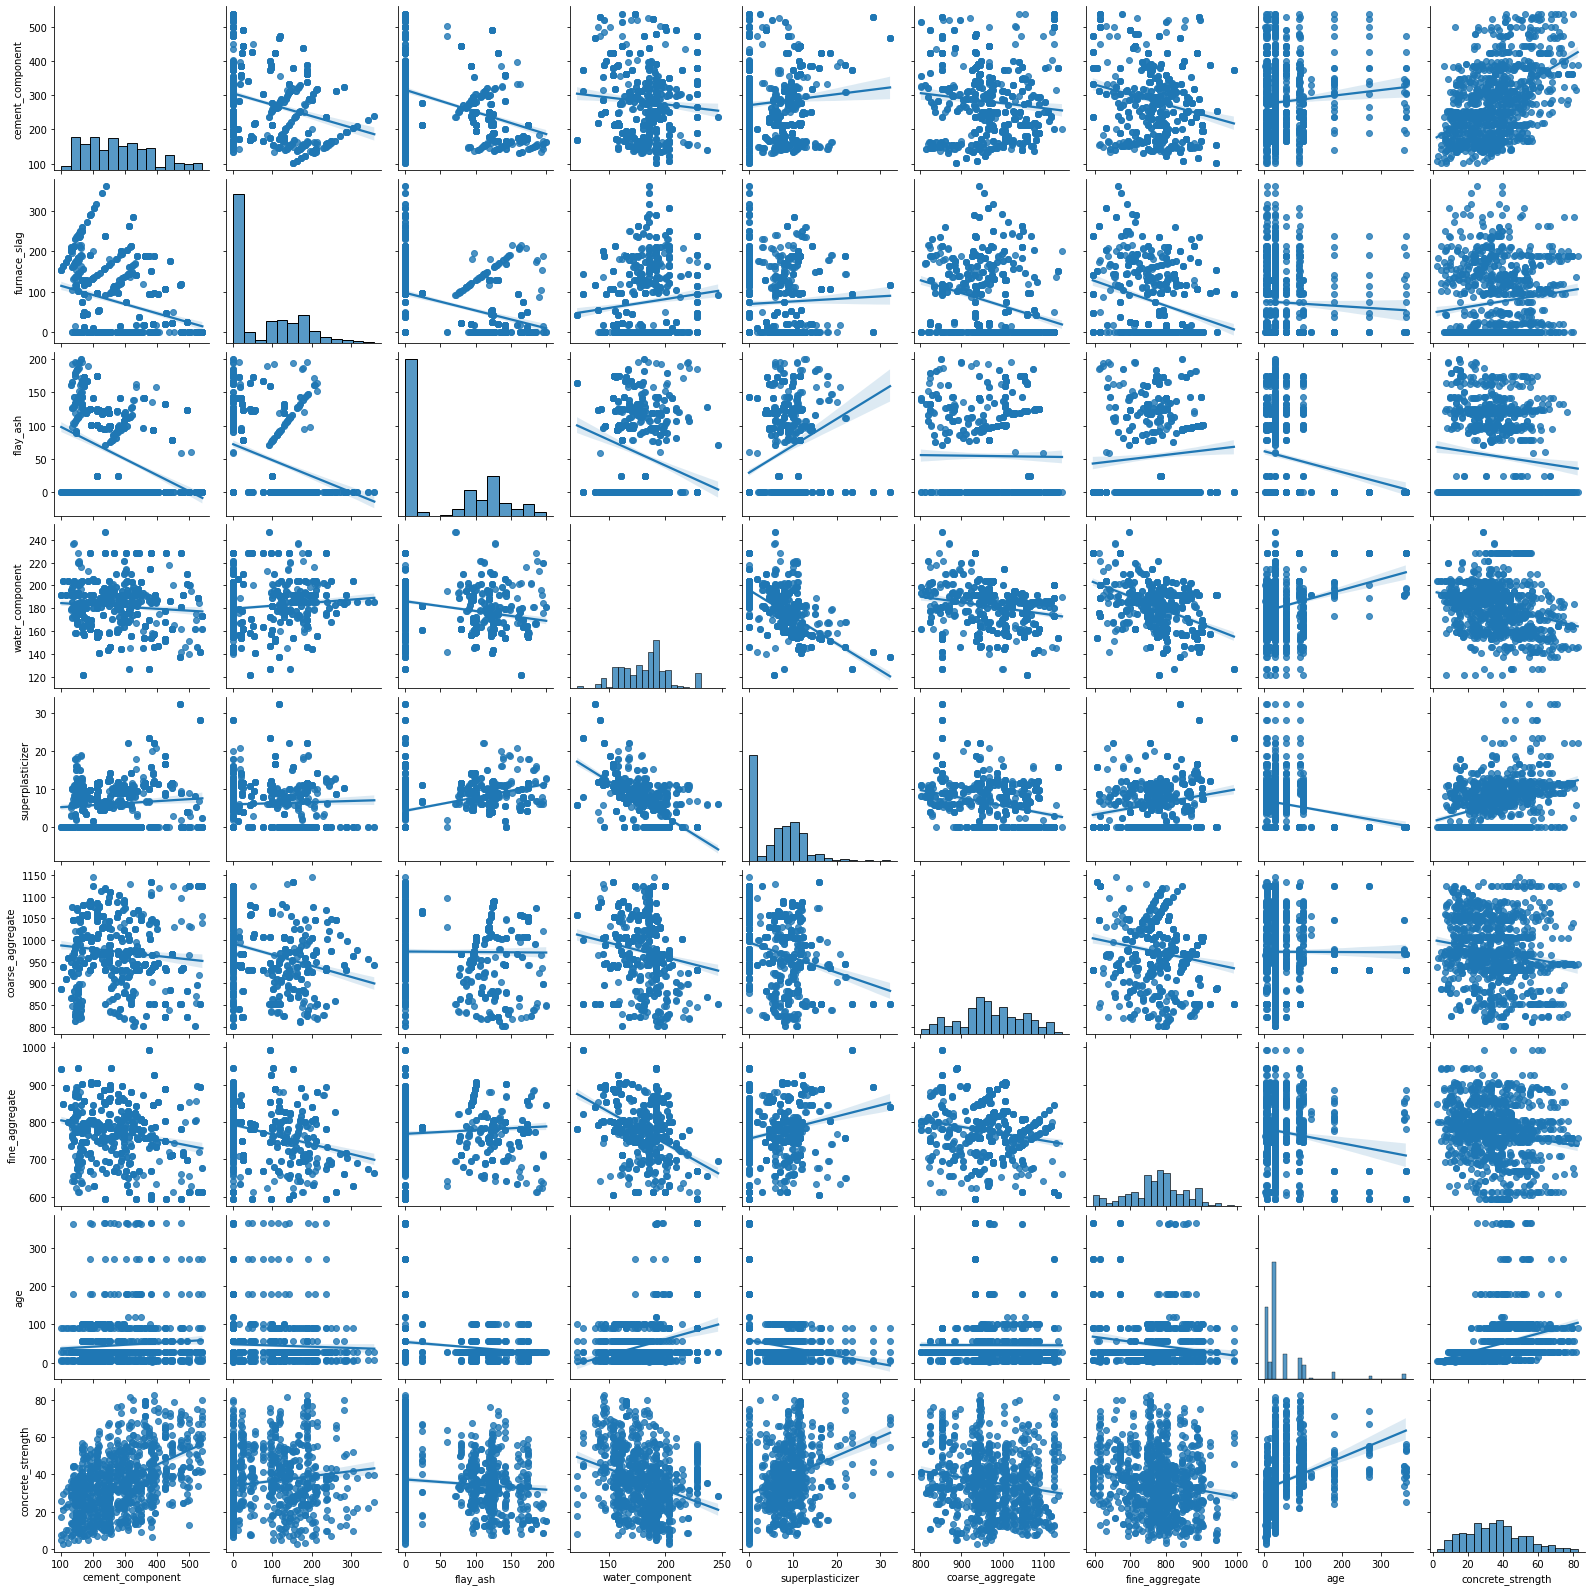

In [10]:
#Calculating Pair Plot Between All Features
%pip install seaborn
data_ = data[(data.T != 0).any()]
seaborn. pairplot(data_, vars=data.columns, kind='reg')
plt.show()

In [11]:
# Splitting the Data in Training and Testing sets
def split_train_test(data, feature, train_index=0.7):
    train, test = train_test_split(data, test_size = 1-train_index)
    if type(feature) == list:
        x_train = train[feature].as_matrix()
        y_train = train['concrete_strength'].as_matrix()
        x_test = test[feature].as_matrix()
        y_test = test['concrete_strength'].as_matrix()
    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]
        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
    return x_train, y_train, x_test, y_test

### LINEAR REGRESSION

cement_component 0.21348716892410935
flay_ash 0.08993365443685797
water_component 0.07747495803109261
superplasticizer 0.0760663581390324
coarse_aggregate 0.02212996964663949


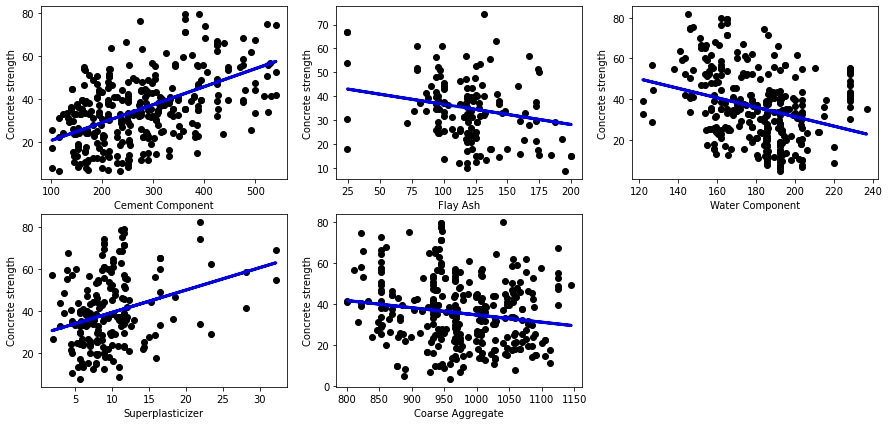

In [12]:
# Calculating Single Linear Regression
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)

    # Create linear regression object
    regr = LinearRegression()
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)
    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue',
    linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))
    plot_count+=1
plt.show()

### Support Vector Machine
- It constructs hyperplane(s) for the purpose of classification and regression.

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.24227552255212814


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


flay_ash -0.051507745606608646


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


water_component 0.07042643986930508


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


superplasticizer 0.09418708745911908


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


coarse_aggregate -0.03311449531597588


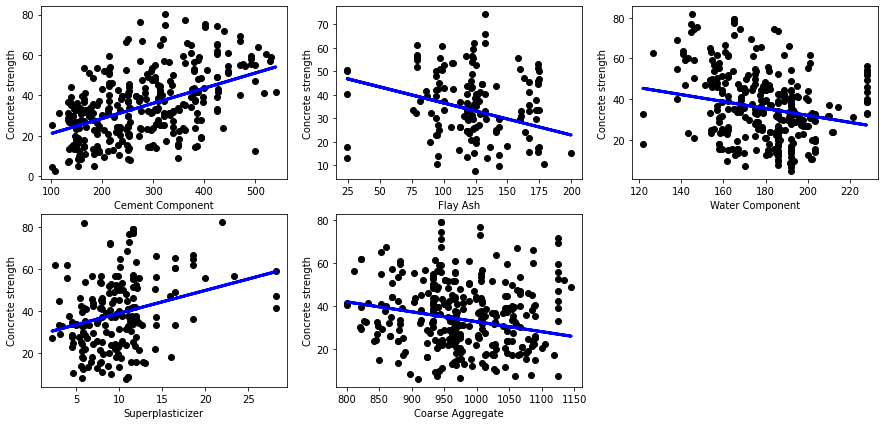

In [14]:
plt.figure(figsize=(15,7))
plot_count = 1

for feature in ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    # Create linear regression object
    regr = SVR(kernel='linear')
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))

    plot_count+=1
plt.show()

#### Gradient Boosting Regression
- This is either classification or regression tree models populates into a gradient boosted model.

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.37062535360510696
flay_ash -0.03793947535531994


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


water_component 0.32945394451327903
superplasticizer 0.15554150824148905


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


coarse_aggregate 0.22245410396214893


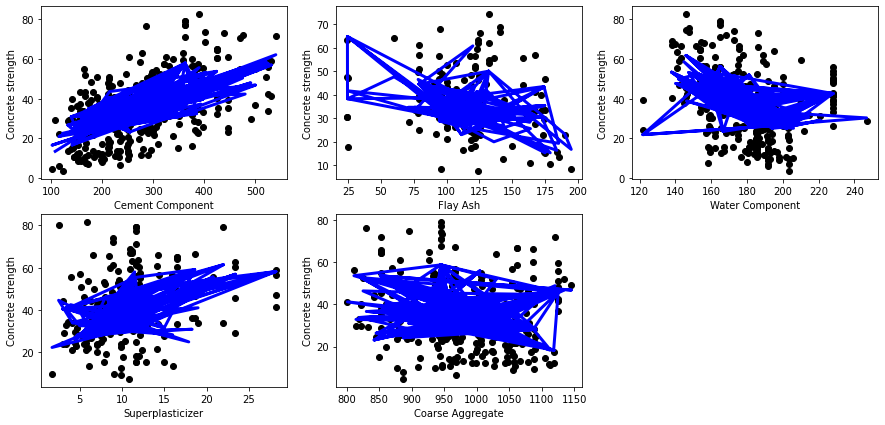

In [15]:
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component',
'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    # Create linear regression object
    regr = GradientBoostingRegressor()
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))
    plot_count+=1
plt.show()

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.222454


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'GradientBoostingRegressor' object has no attribute 'intercept_'

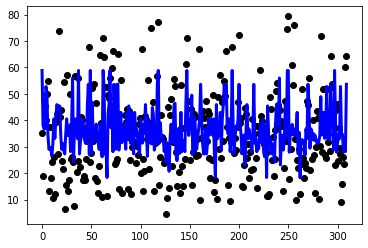

In [17]:
features = ['cement_component', 'flay_ash', 'water_component',
'superplasticizer', 'coarse_aggregate']
model = GradientBoostingRegressor()
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue',
 linewidth=3)
print ('Features: %s'%str(features))
print ('R2 score: %f'%r2_score(y_test, y_pred))
print ('Intercept: %f'%regr.intercept_)
print ('Coefficients: %s'%str(regr.coef_))